In [1]:
# Importation des bibliothèques 
import geopandas as gpd
import rasterstats
import pandas as pd
from rasterstats import zonal_stats
import os 
from osgeo import gdal
import numpy as np
from collections import defaultdict
from my_function import apply_decision_rules, compute_confusion_matrix_with_plots

In [2]:
# Définition des cheminss d'accès 
my_folder = '/home/onyxia/work/Depot_Git/results/data'
sample_filename = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ.shp')
image_filename = os.path.join (my_folder,'classif/carte_essences_echelle_pixel.tif')

In [4]:
# Utilisation de zonal_stats pour obtenir le total des pixels par polygone
zonal_statistics = zonal_stats(
    sample_filename,
    image_filename,
    stats=["count"],  # Nombre total de pixels par polygone
    categorical=True  # Activer le mode catégoriel pour extraire les classes
)

# Chargement de raster pour extraire les classes
raster = gdal.Open(image_filename)
band = raster.GetRasterBand(1)  
raster_data = band.ReadAsArray()

# Boucle pour extraire les classes par polygone
# liste de dictionnaires pour stocker les pourcentages des classes par polygone
polygon_classes_percentages = []

# Parcourir les statistiques zonales
for idx, stats in enumerate(zonal_statistics):
    polygon_id = idx + 1  
    total_pixels = stats["count"]  # Nombre total de pixels dans le polygone

    # Initialisation d'un dictionnaire pour stocker les pourcentages des classes pour ce polygone
    class_percentages = {}
    
    # Parcourir chaque classe dans le polygone
    for class_value, pixel_count in stats.items():
        if class_value == "count":  # Ignorer le total
            continue
        
        # Calcul du pourcentage
        percentage = (pixel_count / total_pixels) * 100
        class_percentages[class_value] = percentage

    #  Ajout de résultats pour ce polygone
    polygon_classes_percentages.append({
        "polygon_id": polygon_id,
        "class_percentages": class_percentages
    })

# Affichage des résultats
for polygon_result in polygon_classes_percentages:
    print(f"Polygone {polygon_result['polygon_id']} :")
    for class_value, percentage in polygon_result["class_percentages"].items():
        print(f"  Classe {class_value}: {percentage:.2f}%")
        
# Transformation de resulats sous forme d'un dataframe pour qu'elle soit utilisée par la suite dans la fonction d'arbre de décision 
df_polygon_classes_percentages= pd.DataFrame(polygon_classes_percentages)


In [5]:

# Ajout des classifications prédites selon les règles de décision
polygons["code_predit"] = apply_decision_rules(df_polygon_classes_percentages, sample_filename)
polygons.head(5)

# Sauvegarder les données avec la nouvelle colonne
output_path_samples = os.path.join (my_folder, "classif/carte_essences_echelle_peuplement.shp")  # Remplacez par le chemin de sortie
polygons.to_file(output_path_samples)

/opt/conda/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/tmp/ipykernel_151962/4190111994.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygons.to_file(output_path_samples)
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'code_predit' to 'code_predi'
  ogr_write(


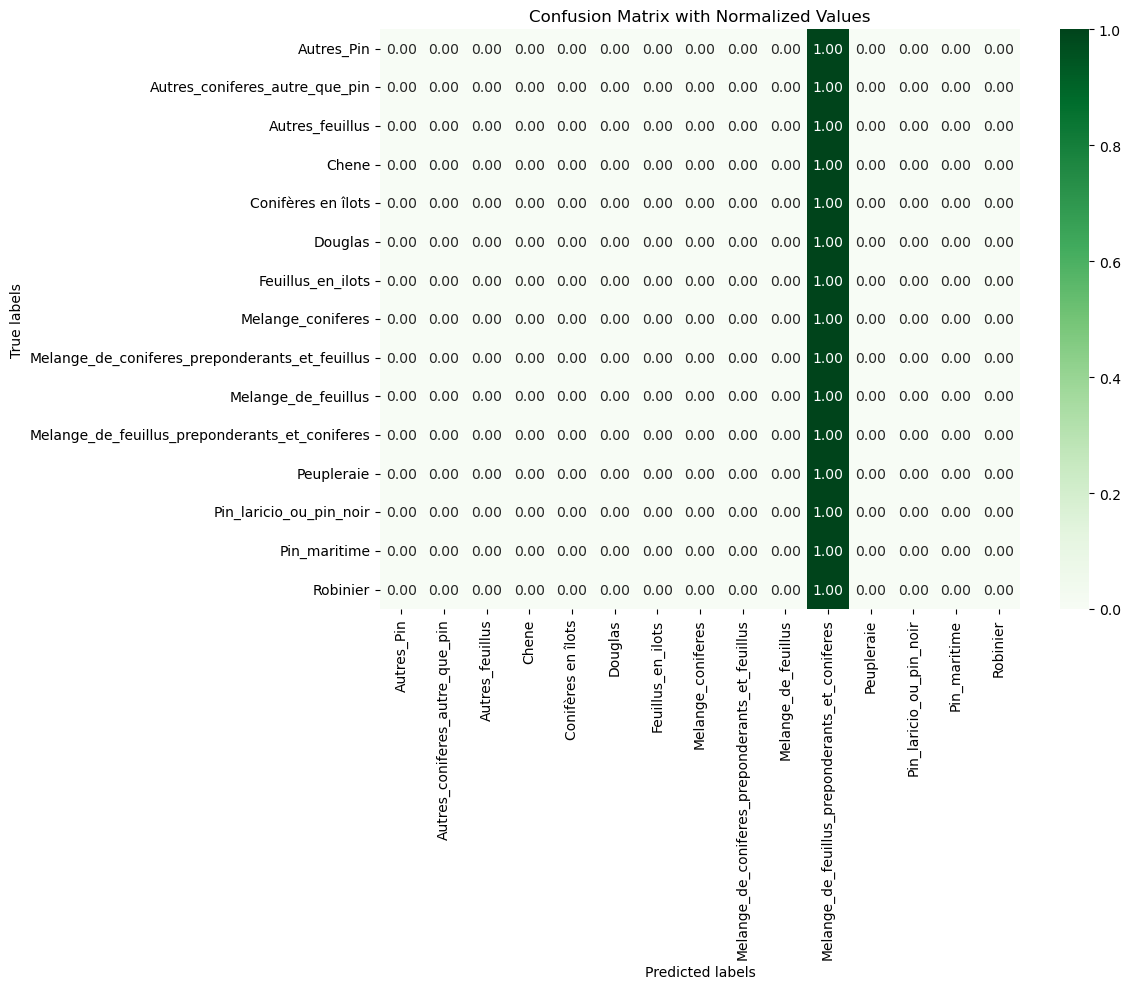

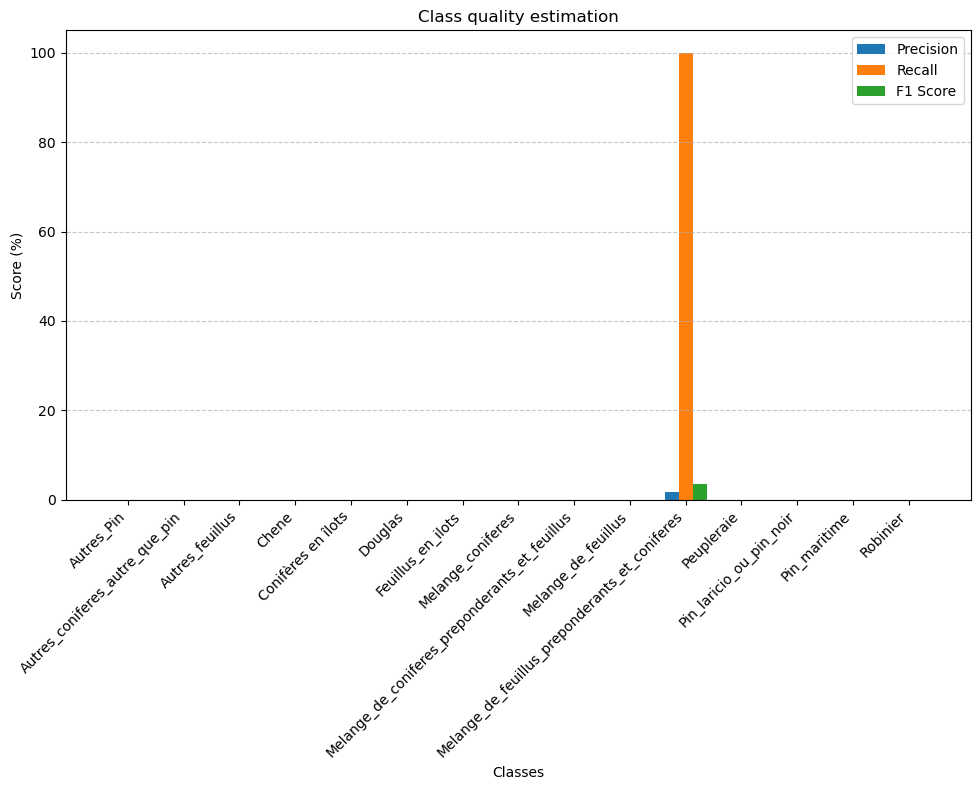

{'confusion_matrix': array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    8,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    5,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  128,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2172,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   39,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   18,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 5325,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   19,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  119,
           0,    0,    0,    0],
       [   0,   

In [6]:
# Calcul de  la matrice de confusion
confusion_matrix = compute_confusion_matrix_with_plots(polygons,"Nom","code_predit")
print(confusion_matrix)